# 1. 数据集
* 数据集：中、英文数据集各一份
* THUCNews中文数据集：https://pan.baidu.com/s/1hugrfRu 密码：qfud
* IMDB英文数据集： [IMDB数据集 Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/)

# 2.IMDB数据集下载和探索模块及指标学习模块

# 3. THUCNews数据集下载和探索
# 4.学习召回率、准确率、ROC曲线、AUC、PR曲线这些基本概念
### 参考资料 
TensorFlow官方教程：影评文本分类  |  TensorFlow (https://tensorflow.google.cn/tutorials/keras/basic_text_classification)
科赛 - Kesci.com (https://www.kesci. com/home/project/5b6c05409889570010ccce90)
博客中的数据集部分和预处理部分：CNN字符级中文文本分类-基于TensorFlow实现 - 一蓑烟雨 - CSDN博客 (https://blog.csdn.net/u011439796/article/details/77692621)
text-classification-cnn-rnn/cnews_loader.py at mas...(https://github.com/gaussic/text-classification-cnn-rnn/blob/master/data/cnews_loader.py)
机器学习之类别不平衡问题 (2) —— ROC和PR曲线_慕课手记(https://www.imooc.com/article/48072)`

# 1. 数据集


Help on function load_data in module tensorflow.python.keras.datasets.imdb:

load_data(path='imdb.npz', num_words=None, skip_top=0, maxlen=None, seed=113, start_char=1, oov_char=2, index_from=3, **kwargs)
    Loads the IMDB dataset.
    
    Arguments:
        path: where to cache the data (relative to `~/.keras/dataset`).
        num_words: max number of words to include. Words are ranked
            by how often they occur (in the training set) and only
            the most frequent words are kept
        skip_top: skip the top N most frequently occurring words
            (which may not be informative).
        maxlen: sequences longer than this will be filtered out.
        seed: random seed for sample shuffling.
        start_char: The start of a sequence will be marked with this character.
            Set to 1 because 0 is usually the padding character.
        oov_char: words that were cut out because of the `num_words`
            or `skip_top` limit will be replaced with this 

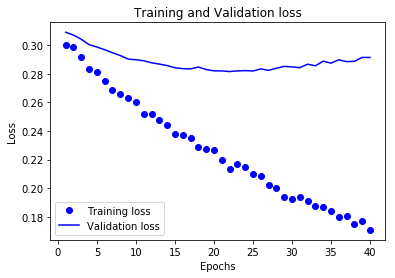

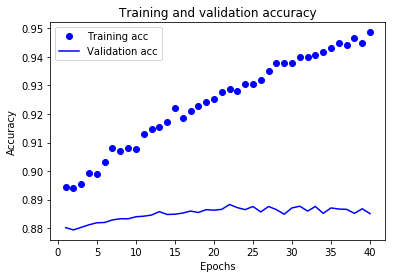

In [4]:
# IMDB 探索
#导入包
import tensorflow as tf
from tensorflow import keras
import numpy as np
#导入iMBD数据集
imdb = keras.datasets.imdb
#探索数据集
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
#分析数据集
help(imdb.load_data)
print("Training shape: {}, labels: {}".format(train_data.shape, train_labels.shape))
print(train_data[:5])
print(train_labels[:5])
#获取前两个文本长度
len(train_data[0]), len(train_data[1])
#获取前三个类别
print(train_labels[:3])
#:
#获取字词-整数字典标签
word_index = imdb.get_word_index()
# reverse_word_index反序字典格式：{序号：单词}
reverse_word_index=dict([(value, key) for (key, value) in word_index.items()])
# 查看前5个序号的单词，注意序号从1开始
for i in range(5):
    print(reverse_word_index[i+1])
# 在开头添加这几个特殊标志，并占用前几个字符
# 上一部得知，序号是从1开始，所以这里+3是正确的，即先把所有序号往后推3位，再添加特殊标志
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
#把字典啊{字符：序号}转化成{序号：字符}的形式
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
for i in range(5):
    print(reverse_word_index[i])
# 定义一个函数，将序号文本转换成单词文本，用空格连接
#揭秘文档，text内容应该都是序号，要转换成字符
def decode_review(text):
    #把序号转换成字符，若有新字符，用？代替。最后并组成一个字符串
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
text0=decode_review(train_data[0])
print(text0)
#影评长度标准化
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)


test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)
len(train_data[0]), len(train_data[1])
#输入形状是用于电影评论的词汇计数（10,000字）
vocab_size = 10000

model = keras.Sequential()
#第一层是 Embedding 层。该层会在整数编码的词汇表中查找每个字词-索引的嵌入向量。
#模型在接受训练时会学习这些向量。这些向量会向输出数组添加一个维度。生成的维度为：(batch, sequence, embedding)。
model.add(keras.layers.Embedding(vocab_size, 16))
# GlobalAveragePooling1D 层通过对序列维度求平均值，针对每个样本返回一个长度固定的输出向量。
#这样，模型便能够以尽可能简单的方式处理各种长度的输入。
model.add(keras.layers.GlobalAveragePooling1D())
#该长度固定的输出向量会传入一个全连接 (Dense) 层（包含 16 个隐藏单元）。
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.5))
#最后一层与单个输出节点密集连接。应用 sigmoid 激活函数后，结果是介于 0 到 1 之间的浮点值，表示概率或置信水平。
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()
#模型损失函数与指定优化函数
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#构建验证集
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#训练模型
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

#训练模型
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
#评估模型
results = model.evaluate(test_data, test_labels)

print(results)
#创建准确率和损失随时间变化的图
history_dict = history.history
history_dict.keys()
# dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
#导入做图包matplotlib
import matplotlib.pyplot as plt
#赋值
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

#损失图
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')     #bo 蓝点
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')     #b 蓝线
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.clf()   # 清图
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



